In [8]:
import yfinance as yf
import pandas as pd
import numpy as np

In [6]:
!pip install --upgrade yfinance

[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open    Volume
Ticker            AMZN        AMZN        AMZN        AMZN      AMZN
Date                                                                
2024-01-02  149.929993  152.380005  148.389999  151.539993  47339400
2024-01-03  148.470001  151.050003  148.330002  149.199997  49425500
2024-01-04  144.570007  147.380005  144.050003  145.589996  56039800
2024-01-05  145.240005  146.589996  144.529999  144.690002  45124800
2024-01-08  149.100006  149.399994  146.149994  146.740005  46757100


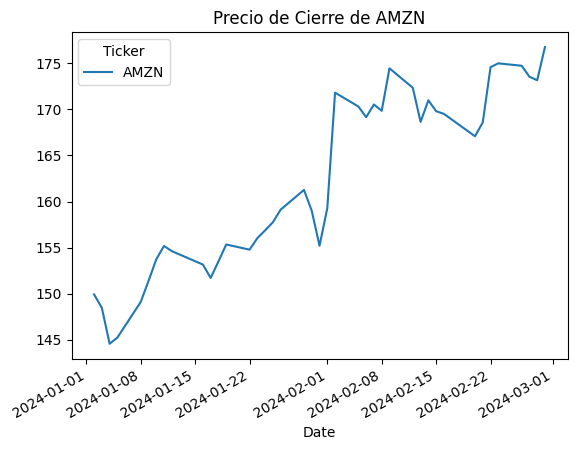

In [51]:
# 1. Especificar el ticker de la acción
ticker = 'AMZN'  # Aquí puedes poner el ticker que desees, por ejemplo, AAPL para Apple

# 2. Descargar los precios históricos usando yfinance
data = yf.download(ticker, start="2024-01-01", end="2024-03-01")  # Especificamos el rango de fechas

# 3. Visualizar los primeros registros
print(data.head())

# 4. Opcional: Graficar los precios de cierre
import matplotlib.pyplot as plt

data['Close'].plot(title=f"Precio de Cierre de {ticker}")
plt.show()

In [52]:
# Eliminar MultiIndex y dejar solo los nombres de las columnas
data.columns = data.columns.droplevel(1)

# Mostrar las primeras filas
print(data.head())

Price            Close        High         Low        Open    Volume
Date                                                                
2024-01-02  149.929993  152.380005  148.389999  151.539993  47339400
2024-01-03  148.470001  151.050003  148.330002  149.199997  49425500
2024-01-04  144.570007  147.380005  144.050003  145.589996  56039800
2024-01-05  145.240005  146.589996  144.529999  144.690002  45124800
2024-01-08  149.100006  149.399994  146.149994  146.740005  46757100


In [53]:
#Vemos la estructura de los datos
data[data.index>'2024-01-01'].head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2024-01-02,149.929993,152.380005,148.389999,151.539993,47339400
2024-01-03,148.470001,151.050003,148.330002,149.199997,49425500
2024-01-04,144.570007,147.380005,144.050003,145.589996,56039800
2024-01-05,145.240005,146.589996,144.529999,144.690002,45124800
2024-01-08,149.100006,149.399994,146.149994,146.740005,46757100


1. Vamos a emplear para el analisis los precios ajustados al cierre.
Estos precios son mas realistas, pues consideran la reparticion de dividendos, splits, consolidaciones comporativas etc

# Definicion del Movimiento Browniano Geometrico

Se ha demostrado matematicamente que el comportamiento de las acciones se puede modelar con un MBG.

$$dS(t) = \mu S(t) dt + \sigma S(t) dB(t)$$

donde:
- $S(t)$ es el precio en el tiempo $t$,
- $\mu$ es la tasa de crecimiento esperada,
- $\sigma$ es la volatilidad,
- $B(t)$ es un proceso de Wiener, tambien conocido como ruido aleatorio.

La solución de esta ecuación es:

$$S(t+1) = S(t) \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma B(t)\right)$$



1. Para calcular $\mu$ en primer lugar debemos calcular los retornos logaritmicos para cada momento $t$

$$rt=ln\left(\frac{st}{st-1}\right)$$

In [54]:
data['retornos']=(data['Close'] / data['Close'].shift(1)).apply(lambda x: np.log(x))
data.head()

Price,Close,High,Low,Open,Volume,retornos
Date,,,,,,
2024-01-02,149.929993,152.380005,148.389999,151.539993,47339400,NaN
2024-01-03,148.470001,151.050003,148.330002,149.199997,49425500,-0.009786
2024-01-04,144.570007,147.380005,144.050003,145.589996,56039800,-0.026619
2024-01-05,145.240005,146.589996,144.529999,144.690002,45124800,0.004624
2024-01-08,149.100006,149.399994,146.149994,146.740005,46757100,0.026230


2. Calculamos la tasa de crecimiento esperada

$$\mu=\frac{1}{N}\sum_{t=1}^{n} rt$$

In [55]:
#Metodo 1
N=len(data)-1 #Menos 1 porque el primer elemento no tiene retorno
mu=data['retornos'].sum()/N
print('el parametro mu del modelo es: ', mu)

el parametro mu del modelo es:  0.004115609488242161


In [56]:
#Metodo 2
data['retornos'].mean()

np.float64(0.004115609488242161)

3. Calculamos la volatilidad $\sigma$

$$\sigma = \sqrt{\frac{1}{N-1} \sum_{t=1}^{N} \left( r_t - \mu \right)^2}$$





In [57]:
#Metodo 1
N = len(data['retornos']) -1 # Número total de retornos
sigma = np.sqrt(np.sum((data['retornos'] - mu)**2) / (N - 1))
print('el parametro sigma del modelo es: ', sigma)

el parametro sigma del modelo es:  0.018412717340685333


In [58]:
#Metodo 2
sigma = data['retornos'].std()
sigma

0.018412717340685333

3. Definimos el proceso estocastico asi:

$$st+1=st*EXP\left[\left(\mu -\frac{\sigma^2}{2}\right)dt+\sigma et \sqrt{dt}\right]\$$

donde,

- dt es 1/252 dias de mercado \newline
- et es un numero aleatorio de una distribucion N(0,1)
- st retorno en el momento t
- st+1 retorno en el momento t+1

In [59]:
#Procedemos a crear una funcion que modele el proceso estocastico
def MGB_acciones(mu,sigma,data,col_name,steps):

    #Los parametros de la funcion son:
    #mu -> Tasa de crecimiento esperada
    #sigma -> volatilidad del activo
    #data -> pandas df que contiene los retornos logaritmicos del activo en dias
    #col_name -> nombre de la columna de los retornos
    #steps -> numero de pasos hacia adelante en el proceso estocastico

    dt=1/252 # son solo 252 dias de traiding en el año.
    s0=data[col_name].iloc[-1] #Tomamos el ultimo elemento de los precios, ya que este sera el punto de partida
    et_vector=np.random.normal(loc=0, scale=1, size=steps) # Vector de numeros aletorios de media 0 y desviacion estandar 1
    exp_vector = np.exp((mu - (sigma**2) / 2) * dt + sigma * et_vector * np.sqrt(dt))

    st_1=[]

    for i in range(0,steps):

        if i==0:
            s=s0*exp_vector[0]
        else:
            s=st_1[i-1]*exp_vector[i]

        st_1.append(s)


    return st_1

#Probamos la funcion
#MGB_acciones(mu, sigma, data, 'Adj Close',252)

In [60]:
# Funcion que realiza graficos de lineas
def lineas_multiples(data, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y'):
    """
    Función para graficar múltiples líneas con colores aleatorios.

    Parámetros:
    - data: DataFrame de pandas con los datos a graficar.
    - title: Título del gráfico.
    - xlabel: Etiqueta del eje X.
    - ylabel: Etiqueta del eje Y.
    """
    plt.figure(figsize=(10, 6))  # Tamaño de la figura
    num_lines = data.shape[1]  # Número de líneas (columnas en el DataFrame)

    # Generar un color aleatorio para cada línea
    colors = np.random.rand(num_lines, 3)  # Colores aleatorios en RGB

    for i in range(num_lines):
        plt.plot(np.arange(1, data.shape[0] + 1), data.iloc[:, i], color=colors[i], label=f'Línea {i + 1}')  # Acceso corregido

    # Configurar título y etiquetas
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Mostrar la cuadrícula
    plt.grid(True)

    # Mostrar leyenda
    #plt.legend()

    # Mostrar el gráfico
    plt.show()

In [62]:
# Ahora simulamos 500 veces cual podria ser el comportamiento del activo el proximo año
Montecarlo_results = pd.DataFrame()

sim=500

for i in range(0,sim):

    print(i)

    Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


<ipython-input-62-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-62-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-62-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


<ipython-input-62-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-62-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-62-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

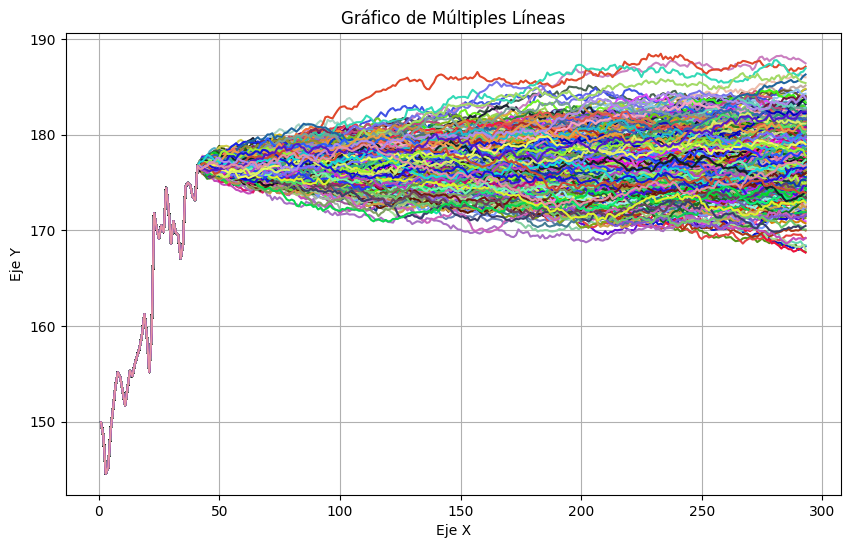

In [63]:
#Graficamos
lineas_multiples(Montecarlo_results, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y')

In [65]:
#Calculamos la probabilidad de perder 5% de la inversion inicial en el próximo año
s0=data['Close'].iloc[-1]
print('El precio de compra es: ', s0)

El precio de compra es:  176.75999450683594


In [66]:
precios_cierre = Montecarlo_results.iloc[-1, :].values #Seleccionamos los precios finales a un año de inversion


In [71]:
total = len(precios_cierre)
exito = (precios_cierre < (s0 * 0.95)).sum()

p = exito / total  # Probabilidad

print(f'Probabilidad de perder al menos 5%: {p*100:.2f}%')

Probabilidad de perder al menos 5%: 0.40%


In [78]:
# Precio inicial
s0 = data['Close'].iloc[-1]
print('El precio de compra es:', s0)

# precios finales después de 1 año
precios_cierre = Montecarlo_results.iloc[-1, :]


total = len(precios_cierre)

# la inversión cae más del 10%
perdida_10 = (precios_cierre < (s0 * 0.90)).sum()

# sube más del 10%
ganancia_10 = (precios_cierre > (s0 * 1.10)).sum()


p_perdida = perdida_10 / total
p_ganancia = ganancia_10 / total

# Mostrar resultados
print(f'Probabilidad de perder al menos 10%: {p_perdida * 100:.2f}%')
print(f'Probabilidad de ganar al menos 10%: {p_ganancia * 100:.2f}%')

El precio de compra es: 176.75999450683594
Probabilidad de perder al menos 10%: 0.00%
Probabilidad de ganar al menos 10%: 0.00%


In [74]:
print(f'Mínimo precio final: {precios_cierre.min()}')
print(f'Máximo precio final: {precios_cierre.max()}')

Mínimo precio final: 167.68680390738123
Máximo precio final: 187.47738716688096
